In [1]:
import sys
import os

# Equivalent without using __file__, assuming you're in notebooks/
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from AllocationFinder import AllocationFinder
from MemBlock import MemBlock
from models import get_relax_mnist

In [2]:
import networkx as nx

module = get_relax_mnist()
alloc_finder = AllocationFinder(module)
alloc_finder.walk()

In [3]:
alloc_finder.memblocks["fused_conv2d_add_relu"][0].name

'pad_temp'

In [4]:
def build_memblock_graph(memblocks):
    G = nx.DiGraph()
    for func, mb_list in memblocks.items():
        print(f"func {func}")
        for mb in mb_list:
            print(f"mb : {mb} id {mb._id}")
            G.add_node(mb._id, label=mb.name, fn_from=func, shape=mb.shape, dtype=mb.dtype)
            print(f" --> {G}")
            for dep in mb.depends_on:
                G.add_edge(dep._id, mb._id)  # dependency edge
    return G

graph = build_memblock_graph(alloc_finder.memblocks)

func forward
mb : MemBlock(x:d007b287, shape=(1, 3, 128, 128), dtype=float32, size=196608, origin=relax.input) id d007b287
 --> DiGraph with 1 nodes and 0 edges
mb : MemBlock(conv1_weight:ce6abce4, shape=(32, 3, 5, 5), dtype=float32, size=9600, origin=relax.input) id ce6abce4
 --> DiGraph with 2 nodes and 0 edges
mb : MemBlock(conv1_bias:4523b3ab, shape=(32,), dtype=float32, size=128, origin=relax.input) id 4523b3ab
 --> DiGraph with 3 nodes and 0 edges
mb : MemBlock(conv2_weight:5e992f67, shape=(64, 32, 5, 5), dtype=float32, size=204800, origin=relax.input) id 5e992f67
 --> DiGraph with 4 nodes and 0 edges
mb : MemBlock(conv2_bias:56ee3aa3, shape=(64,), dtype=float32, size=256, origin=relax.input) id 56ee3aa3
 --> DiGraph with 5 nodes and 0 edges
mb : MemBlock(lv1:516d9447, shape=(1, 32, 1, 1), dtype=float32, size=128, origin=relax.call_tir.reshape) id 516d9447
 --> DiGraph with 6 nodes and 0 edges
mb : MemBlock(lv:32d0cbd3, shape=(1, 32, 128, 128), dtype=float32, size=2097152, origin

In [5]:
alloc_finder.id_to_memblock

{'d007b287': MemBlock(x:d007b287, shape=(1, 3, 128, 128), dtype=float32, size=196608, origin=relax.input),
 'ce6abce4': MemBlock(conv1_weight:ce6abce4, shape=(32, 3, 5, 5), dtype=float32, size=9600, origin=relax.input),
 '4523b3ab': MemBlock(conv1_bias:4523b3ab, shape=(32,), dtype=float32, size=128, origin=relax.input),
 '5e992f67': MemBlock(conv2_weight:5e992f67, shape=(64, 32, 5, 5), dtype=float32, size=204800, origin=relax.input),
 '56ee3aa3': MemBlock(conv2_bias:56ee3aa3, shape=(64,), dtype=float32, size=256, origin=relax.input),
 '516d9447': MemBlock(lv1:516d9447, shape=(1, 32, 1, 1), dtype=float32, size=128, origin=relax.call_tir.reshape),
 '32d0cbd3': MemBlock(lv:32d0cbd3, shape=(1, 32, 128, 128), dtype=float32, size=2097152, origin=relax.call_tir.fused_conv2d_add_relu),
 'a6dcc9de': MemBlock(lv3:a6dcc9de, shape=(1, 64, 1, 1), dtype=float32, size=256, origin=relax.call_tir.reshape1),
 '7abdc45b': MemBlock(gv:7abdc45b, shape=(1, 64, 128, 128), dtype=float32, size=4194304, origin=

In [6]:
import networkx as nx

def netron_style_layout_with_spine(G, vertical_spacing=100, horizontal_spacing=150):
    """
    Netron-style layout for DAGs: center the longest path (spine), place others around.

    Args:
        G: A NetworkX DAG.
        vertical_spacing: Y-distance between layers.
        horizontal_spacing: X-distance between sibling branches.

    Returns:
        pos: Dict mapping node -> (x, y)
    """
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("Graph must be a DAG")

    # Step 1: Longest path via dynamic programming over topological order
    top_order = list(nx.topological_sort(G))
    longest_path = {node: 0 for node in top_order}
    predecessor = {node: None for node in top_order}

    for node in top_order:
        for succ in G.successors(node):
            # print(f"node {node} succ {succ} longest_path[node] + 1 ({longest_path[node] + 1}) > longest_path[succ] ({longest_path[succ]}) => {longest_path[node] + 1 > longest_path[succ]}")
            if longest_path[node] + 1 > longest_path[succ]:
                longest_path[succ] = longest_path[node] + 1
                predecessor[succ] = node  # WARNING : More complex graphs with multiple predecessor may not be handled well

    # print(f"predecessor {predecessor}")
    # print(f"longest_path {longest_path}")

    # Find end of longest path
    end_node = max(longest_path, key=lambda n: longest_path[n])
    # Reconstruct path backwards
    spine = []
    n = end_node
    while n is not None:
        spine.append(n)
        n = predecessor[n]
    spine.reverse()

    # Step 2: Assign vertical layer (depth)
    node_depth = {}
    for node in top_order:
        preds = list(G.predecessors(node))
        if not preds:
            node_depth[node] = 0
        else:
            node_depth[node] = max(node_depth[p] + 1 for p in preds)

    # Step 3: Place spine nodes on x = 0
    pos = {}
    layer_to_spine_x = {}

    for node in spine:
        y = -node_depth[node] * vertical_spacing
        pos[node] = (0, y)
        layer_to_spine_x[node_depth[node]] = 0

    # Step 4: Place side nodes to left/right of spine, respecting predecessor side if any
    side_counters = {}  # depth -> alternation counter

    for node in top_order:
        if node in pos:
            continue  # already placed (on spine)

        depth = node_depth[node]
        preds = list(G.predecessors(node))
        pred_xs = [pos[p][0] for p in preds if p in pos]

        # Try to respect the side of already-placed predecessors
        if pred_xs:
            avg_x = sum(pred_xs) / len(pred_xs)
            if avg_x > horizontal_spacing / 2:
                side = "right"
            elif avg_x < -horizontal_spacing / 2:
                side = "left"
            else:
                side = None
        else:
            side = None

        # Decide placement
        counter = side_counters.get(depth, 0)
        if side == "left":
            direction = -1
            index = sum(1 for x in pred_xs if x < 0) + 1
        elif side == "right":
            direction = 1
            index = sum(1 for x in pred_xs if x > 0) + 1
        else:
            direction = -1 if counter % 2 == 0 else 1  # alternate
            index = counter // 2 + 1

        x = direction * index * horizontal_spacing
        y = -depth * vertical_spacing
        pos[node] = (x, y)

        side_counters[depth] = counter + 1


    return pos

netron_style_layout_with_spine(graph)

{'d007b287': (0, 0),
 'd8d42eab': (0, -100),
 'eba01b42': (0, -200),
 'd93b7024': (0, -300),
 '32d0cbd3': (0, -400),
 'de3aec92': (0, -500),
 'f16efbd9': (0, -600),
 'f2dceb7f': (0, -700),
 '7abdc45b': (0, -800),
 'ce6abce4': (-150, 0),
 '4523b3ab': (150, 0),
 '5e992f67': (-300, 0),
 '56ee3aa3': (300, 0),
 '516d9447': (300, -100),
 'a6dcc9de': (300, -100)}

In [7]:
import networkx as nx

def netron_style_layout_balanced(G, vertical_spacing=100, horizontal_spacing=150):
    """
    Netron-style layout for DAGs with balanced left-right branch placement.

    Args:
        G: A NetworkX directed acyclic graph (DAG).
        vertical_spacing: Vertical distance between layers (y-axis).
        horizontal_spacing: Horizontal distance between branches (x-axis).

    Returns:
        pos: A dict mapping each node to its (x, y) plot position.
    """
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("Graph must be a DAG")

    # Step 1: Find the longest path ("spine") using dynamic programming
    top_order = list(nx.topological_sort(G))
    dist = {node: 0 for node in top_order}
    pred = {node: None for node in top_order}

    for node in top_order:
        for succ in G.successors(node):
            if dist[node] + 1 > dist[succ]:
                dist[succ] = dist[node] + 1
                pred[succ] = node

    end_node = max(dist, key=dist.get)
    spine = []
    n = end_node
    while n is not None:
        spine.append(n)
        n = pred[n]
    spine.reverse()

    # Step 2: Assign depth based on topological layer
    node_depth = {}
    for node in top_order:
        preds = list(G.predecessors(node))
        if not preds:
            node_depth[node] = 0
        else:
            node_depth[node] = max(node_depth[p] + 1 for p in preds)

    # Step 3: Place spine nodes vertically at x=0
    pos = {}
    for node in spine:
        y = -node_depth[node] * vertical_spacing
        pos[node] = (0, y)

    # Step 4: Place side branches to left and right
    occupied_slots = set()  # (depth, x) tuples to avoid overlaps

    # Pre-fill occupied positions for spine nodes
    for node in spine:
        x, y = pos[node]
        depth = node_depth[node]
        occupied_slots.add((depth, x))

    for node in top_order:
        if node in pos:
            continue  # already placed on the spine

        depth = node_depth[node]
        y = -depth * vertical_spacing

        # Heuristic: determine placement side based on predecessors
        preds = list(G.predecessors(node))
        pred_xs = [pos[p][0] for p in preds if p in pos]

        side = None
        if pred_xs:
            avg_x = sum(pred_xs) / len(pred_xs)
            if avg_x > horizontal_spacing / 2:
                side = "right"
            elif avg_x < -horizontal_spacing / 2:
                side = "left"

        # Try to place node on preferred side, or alternate outward from spine
        max_attempts = 10
        for i in range(1, max_attempts):
            if side == "left":
                x_try = -i * horizontal_spacing
            elif side == "right":
                x_try = i * horizontal_spacing
            else:
                # If side unclear, try left then right outward from center
                x_try = (-1)**i * ((i + 1) // 2) * horizontal_spacing

            if (depth, x_try) not in occupied_slots:
                pos[node] = (x_try, y)
                occupied_slots.add((depth, x_try))
                break
        else:
            # Fallback if all slots are taken: place far right
            fallback_x = (max_attempts + 1) * horizontal_spacing
            pos[node] = (fallback_x, y)
            occupied_slots.add((depth, fallback_x))

    return pos


In [8]:
alloc_finder.id_to_memblock

{'d007b287': MemBlock(x:d007b287, shape=(1, 3, 128, 128), dtype=float32, size=196608, origin=relax.input),
 'ce6abce4': MemBlock(conv1_weight:ce6abce4, shape=(32, 3, 5, 5), dtype=float32, size=9600, origin=relax.input),
 '4523b3ab': MemBlock(conv1_bias:4523b3ab, shape=(32,), dtype=float32, size=128, origin=relax.input),
 '5e992f67': MemBlock(conv2_weight:5e992f67, shape=(64, 32, 5, 5), dtype=float32, size=204800, origin=relax.input),
 '56ee3aa3': MemBlock(conv2_bias:56ee3aa3, shape=(64,), dtype=float32, size=256, origin=relax.input),
 '516d9447': MemBlock(lv1:516d9447, shape=(1, 32, 1, 1), dtype=float32, size=128, origin=relax.call_tir.reshape),
 '32d0cbd3': MemBlock(lv:32d0cbd3, shape=(1, 32, 128, 128), dtype=float32, size=2097152, origin=relax.call_tir.fused_conv2d_add_relu),
 'a6dcc9de': MemBlock(lv3:a6dcc9de, shape=(1, 64, 1, 1), dtype=float32, size=256, origin=relax.call_tir.reshape1),
 '7abdc45b': MemBlock(gv:7abdc45b, shape=(1, 64, 128, 128), dtype=float32, size=4194304, origin=

In [9]:
id_to_labels = {}
for key, params in graph.nodes(data=True):
    # id_to_labels[key] = params["fn_from"] + ":" + params["label"]
    id_to_labels[key] = params["label"]

In [10]:
list(graph.nodes)[0]

'd007b287'

In [11]:
alloc_finder.id_to_memblock

{'d007b287': MemBlock(x:d007b287, shape=(1, 3, 128, 128), dtype=float32, size=196608, origin=relax.input),
 'ce6abce4': MemBlock(conv1_weight:ce6abce4, shape=(32, 3, 5, 5), dtype=float32, size=9600, origin=relax.input),
 '4523b3ab': MemBlock(conv1_bias:4523b3ab, shape=(32,), dtype=float32, size=128, origin=relax.input),
 '5e992f67': MemBlock(conv2_weight:5e992f67, shape=(64, 32, 5, 5), dtype=float32, size=204800, origin=relax.input),
 '56ee3aa3': MemBlock(conv2_bias:56ee3aa3, shape=(64,), dtype=float32, size=256, origin=relax.input),
 '516d9447': MemBlock(lv1:516d9447, shape=(1, 32, 1, 1), dtype=float32, size=128, origin=relax.call_tir.reshape),
 '32d0cbd3': MemBlock(lv:32d0cbd3, shape=(1, 32, 128, 128), dtype=float32, size=2097152, origin=relax.call_tir.fused_conv2d_add_relu),
 'a6dcc9de': MemBlock(lv3:a6dcc9de, shape=(1, 64, 1, 1), dtype=float32, size=256, origin=relax.call_tir.reshape1),
 '7abdc45b': MemBlock(gv:7abdc45b, shape=(1, 64, 128, 128), dtype=float32, size=4194304, origin=

In [12]:
alloc_finder.id_to_memblock["a6dcc9de"].depends_on

[MemBlock(conv2_bias:56ee3aa3, shape=(64,), dtype=float32, size=256, origin=relax.input)]

In [13]:
alloc_finder.id_to_memblock["4523b3ab"].links_to

[MemBlock(lv1:516d9447, shape=(1, 32, 1, 1), dtype=float32, size=128, origin=relax.call_tir.reshape)]

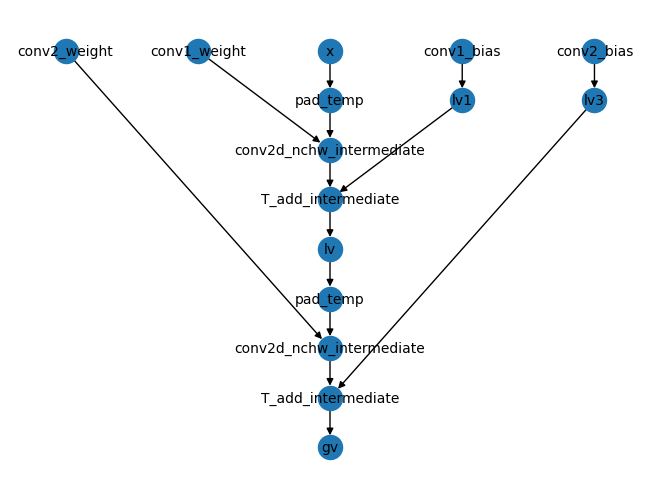

In [15]:
import matplotlib.pyplot as plt
import networkx.drawing.layout as nxl

nx.draw(graph, with_labels=True, labels=id_to_labels, font_size=10, node_size=300, pos=netron_style_layout_balanced(graph))